In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class, get_dataloader
from src.model.sequence_classification.trainer import SequenceClassificationTrainer

import re
from typing import List, Dict
    

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
!mkdir logs
model_name = "Finetuning"
dataset_name = "RAFT-ETHOS"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

mkdir: cannot create directory ‘logs’: File exists


## Get data

In [5]:
dataset = load_dataset(
    "ethos", 
    name= "binary",
    cache_dir= "/Data/pedro.silva"
)

Generating train split:   0%|          | 0/998 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 998
    })
})

In [7]:
train_dataset = dataset['train']

In [8]:
classes = np.unique(train_dataset['label'], return_counts=True)
classes

(array([0, 1]), array([565, 433]))

In [10]:
classes_names = ["non hate speech", "hate speech"]

In [11]:
num_classes = len(classes[0])

In [12]:
num_classes

2

In [13]:
train_df = train_dataset.to_pandas()


In [14]:
proportion = train_df['label'].value_counts()/len(train_df)

In [15]:
proportion

label
0    0.566132
1    0.433868
Name: count, dtype: float64

In [17]:

def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float,
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    
    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': []
    }

    validation_data = {
        "label" : [],
        "text": []
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = round(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

## Few shot learning study - 50 shots

In [18]:
n_shots = 50
train_validation, test = stratified_train_test_split(
    train_df,
    classes,
    n_shots
)

In [19]:
train, val = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [22]:
val = pd.DataFrame(val).to_dict('list')
test = pd.DataFrame(test).sample(frac = 1).to_dict('list')

In [23]:
np.unique(train['label'], return_counts=True)

(array([0, 1]), array([17, 13]))

In [24]:
np.unique(val['label'],return_counts=True)

(array([0, 1]), array([11,  9]))

In [25]:
np.unique(test['label'],return_counts=True)

(array([0, 1]), array([537, 411]))

## Focal Loss Fn

In [26]:
_, class_counts = np.unique(
    train['label'],
    return_counts=True,
)

alpha = len(train['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val['label'],
    return_counts=True,
)
alpha_val = len(val['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test['label'],
    return_counts=True,
)
alpha_test = len(test['label'])/class_counts_test

In [27]:
alpha, alpha_val, alpha_test

(array([1.76470588, 2.30769231]),
 array([1.81818182, 2.22222222]),
 array([1.76536313, 2.30656934]))

In [28]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 1,
    alpha= alpha,
    device = "cuda"
)

In [31]:
bert = AutoModelForSequenceClassification\
    .from_pretrained(
        "bert-base-uncased", 
        num_labels = num_classes,
        cache_dir = "/Data/pedro.silva"    
    )\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir = "/Data/pedro.silva"  )

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['label'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
    # shuffle = True
)


val_dataloader = get_dataloader(
    val['text'],
    val['label'],
    tokenizer,
    n_shots = len(val['text']),
    num_classes=num_classes,
    equalize_class=False,
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= binary_f1_score,
    n_epochs=15
)


Epoch 14
f1: 0.1666666716337204
tensor([[9, 2],
        [8, 1]], device='cuda:0')


Text(0, 0.5, 'F1 score')

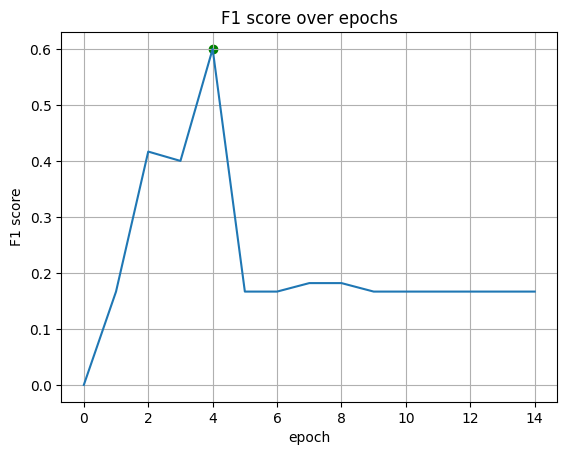

In [32]:
plt.plot(history['val_f1'])

plt.scatter(
    np.argmax(history['val_f1']),
    np.max(history['val_f1']),
    label = f"f1 = {np.max(history['val_f1'])}",
    c = "green"
)

plt.grid()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")

Text(0.5, 1.0, 'Confusion Matrix RAFT-ETHOS - validation')

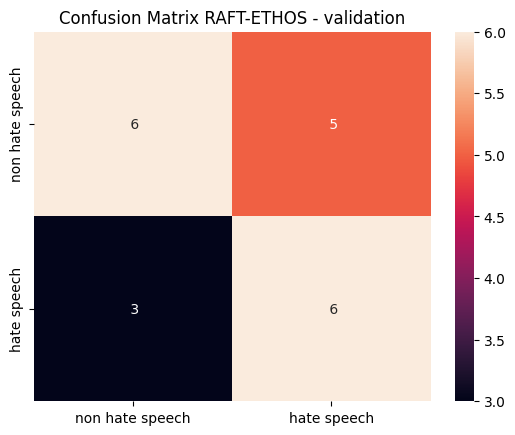

In [33]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - validation")

## Generating Test results

In [34]:
model = trainer.best_model
submission = pd.DataFrame()

with torch.no_grad():
    for i in tqdm(range(len(test['text']))):
        text = test['text'][i]
        label = test['label'][i]

        tokens = tokenizer(
            text,
            truncation= True,
            padding= "max_length",
            return_tensors= "pt",
            max_length=256,
        )

        for k,v in tokens.items():
            tokens[k] = v.to(device)

        pred = model(**tokens)\
            .logits\
            .argmax()\
            .to('cpu')\
            .item()

        this_row = pd.DataFrame({"predicted": pred, "label": label}, index = [i])

        submission = pd.concat([submission, this_row],)

  1%|▏         | 13/948 [00:00<00:07, 121.28it/s]

100%|██████████| 948/948 [00:07<00:00, 121.93it/s]


In [35]:
submission

,predicted,label
0,1,1
1,1,0
2,1,1
3,0,0
4,0,0
...,...,...
943,1,0
944,1,1
945,1,0
946,1,0


In [36]:
from sklearn.metrics import f1_score, confusion_matrix

In [37]:
f1_score(submission['label'], submission['predicted'])

0.5044510385756676

Text(0.5, 1.0, 'Confusion Matrix RAFT-ETHOS - test')

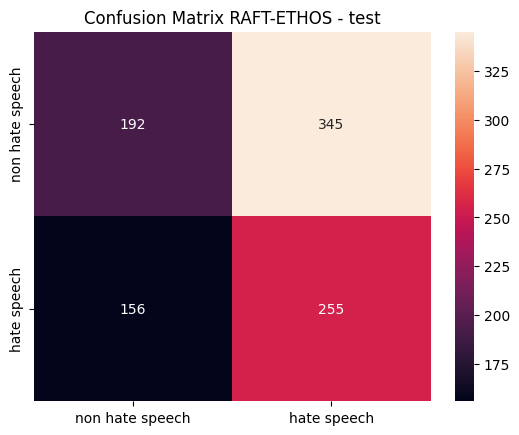

In [38]:
conf_matrix = confusion_matrix(
    submission['label'], 
    submission['predicted']
)

df = pd.DataFrame(
    conf_matrix,
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - test")

## General study - 500 shots

In [39]:
train_df

,text,label
0,You should know women's sports are a joke,1
1,You look like Sloth with deeper Down’s syndrome,1
2,You look like Russian and speak like Indian. B...,1
3,"Women deserve to be abused, I guess.",1
4,Women are made for making babies and cooking d...,1
...,...,...
993,From the midnight sun where the hot springs blow,0
994,Don't say I'm not your type,0
995,And therefore never send to know for whom the...,0
996,And I can't stand another day,0


In [40]:
n_shots = 500
train_validation, test = stratified_train_test_split(
    train_df,
    classes,
    n_shots
)

In [41]:
train, val = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    300
)

In [43]:
val = pd.DataFrame(val).to_dict('list')
test = pd.DataFrame(test).sample(frac = 1).to_dict('list')

In [44]:
np.unique(train['label'], return_counts=True)

(array([0, 1]), array([170, 130]))

In [45]:
np.unique(val['label'],return_counts=True)

(array([0, 1]), array([113,  87]))

In [46]:
np.unique(test['label'],return_counts=True)

(array([0, 1]), array([282, 216]))

## Focal Loss Fn

In [47]:
_, class_counts = np.unique(
    train['label'],
    return_counts=True,
)

alpha = len(train['label'])/class_counts

# ------------ val -----------------------------------

_, class_counts_val = np.unique(
    val['label'],
    return_counts=True,
)
alpha_val = len(val['label'])/class_counts_val

# ----------- test ------------------------------------

_, class_counts_test = np.unique(
    test['label'],
    return_counts=True,
)
alpha_test = len(test['label'])/class_counts_test

In [48]:
alpha, alpha_val, alpha_test

(array([1.76470588, 2.30769231]),
 array([1.7699115 , 2.29885057]),
 array([1.76595745, 2.30555556]))

In [49]:
from src.utils import FocalLoss
loss_fn = FocalLoss(
    gamma= 1,
    alpha= alpha,
    device = "cuda"
)

In [60]:
bert = AutoModelForSequenceClassification\
    .from_pretrained(
        "bert-base-uncased", 
        num_labels = num_classes,
        cache_dir = "/Data/pedro.silva"    
    )\
    .to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", cache_dir = "/Data/pedro.silva"  )

trainer = SequenceClassificationTrainer(
    bert,
    num_classes
)
n_shots = len(train['text'])

train_dataloader = get_dataloader(
    train['text'],
    train['label'],
    tokenizer,
    n_shots= n_shots,
    equalize_class= False,
    num_classes= num_classes,
    batch_size = 8
)


val_dataloader = get_dataloader(
    val['text'],
    val['label'],
    tokenizer,
    n_shots = 300,
    num_classes=num_classes,
    equalize_class=False,
)


history = trainer.compile(
    train_dataloader,
    val_dataloader,
    loss_fn= loss_fn,
    evaluation_fn= binary_f1_score,
    n_epochs=10
)


Epoch 9
f1: 0.5269461274147034
tensor([[77, 36],
        [43, 44]], device='cuda:0')


Text(0, 0.5, 'F1 score')

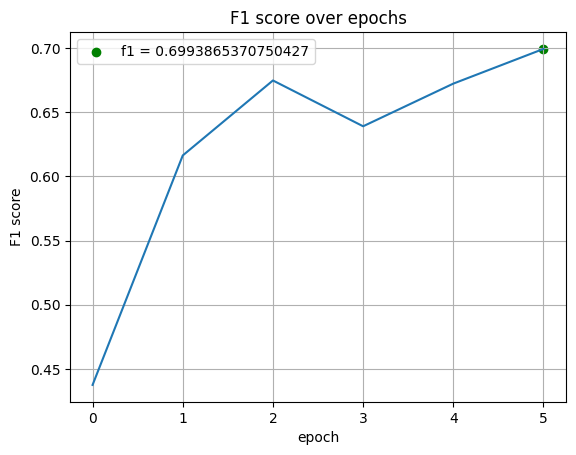

In [52]:
plt.plot(history['val_f1'])

plt.scatter(
    np.argmax(history['val_f1']),
    np.max(history['val_f1']),
    label = f"f1 = {np.max(history['val_f1'])}",
    c = "green"
)

plt.grid()
plt.legend()
plt.title("F1 score over epochs")
plt.xlabel("epoch")
plt.ylabel("F1 score")

Text(0.5, 1.0, 'Confusion Matrix RAFT-ETHOS - validation')

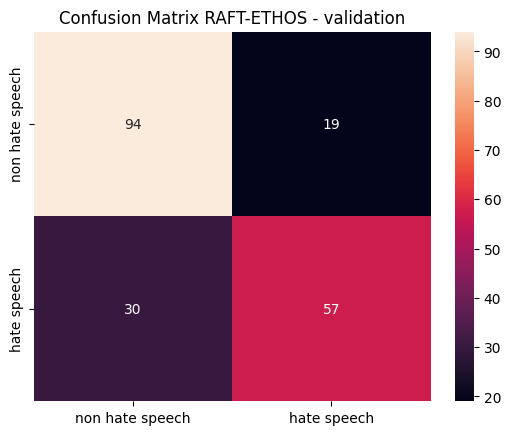

In [53]:
df = pd.DataFrame(
    history['val_conf_matrix'].to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - validation")

## Generating Test results

In [54]:
model = trainer.best_model
submission = pd.DataFrame()

with torch.no_grad():
    for i in tqdm(range(len(test['text']))):
        text = test['text'][i]
        label = test['label'][i]

        tokens = tokenizer(
            text,
            truncation= True,
            padding= "max_length",
            return_tensors= "pt",
            max_length=256,
        )

        for k,v in tokens.items():
            tokens[k] = v.to(device)

        pred = model(**tokens)\
            .logits\
            .argmax()\
            .to('cpu')\
            .item()

        this_row = pd.DataFrame({"predicted": pred, "label": label}, index = [i])

        submission = pd.concat([submission, this_row],)

  3%|▎         | 13/498 [00:00<00:04, 121.13it/s]

100%|██████████| 498/498 [00:04<00:00, 109.78it/s]


In [55]:
submission

,predicted,label
0,0,0
1,1,1
2,0,0
3,0,0
4,0,1
...,...,...
493,0,1
494,0,0
495,0,1
496,0,1


In [56]:
from sklearn.metrics import f1_score, confusion_matrix

In [58]:
f1_score(submission['label'], submission['predicted'])

0.5333333333333333

Text(0.5, 1.0, 'Confusion Matrix RAFT-ETHOS - test')

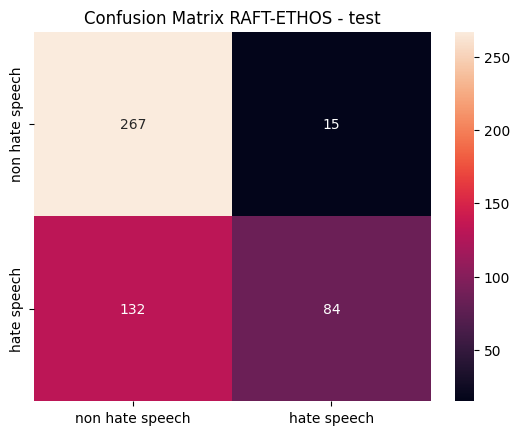

In [59]:
conf_matrix = confusion_matrix(
    submission['label'], 
    submission['predicted']
)

df = pd.DataFrame(
    conf_matrix,
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - test")